In [1]:
# Create an Excel template the user can fill to compute category shares (2020–2025).
import pandas as pd
from openpyxl import Workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import Alignment, Font
from openpyxl.worksheet.table import Table, TableStyleInfo

# File path
path = "/mnt/data/category_shares_2020_2025.xlsx"

# Create workbook and sheets
wb = Workbook()
ws_input = wb.active
ws_input.title = "Input"

# Headers for Input sheet
headers = ["Year", "Appliances", "Electronics", "Clothing", "HomeGoods"]
ws_input.append(headers)

# Pre-fill years 2020-2025
for year in range(2020, 2026):
    ws_input.append([year, "", "", "", ""])

# Style header
for col_idx, h in enumerate(headers, start=1):
    cell = ws_input.cell(row=1, column=col_idx)
    cell.font = Font(bold=True)
    ws_input.column_dimensions[get_column_letter(col_idx)].width = 15

# Add an Excel table to Input
table = Table(displayName="Sales", ref=f"A1:E7")
style = TableStyleInfo(name="TableStyleMedium2", showFirstColumn=False,
                       showLastColumn=False, showRowStripes=True, showColumnStripes=False)
table.tableStyleInfo = style
ws_input.add_table(table)

# Shares sheet
ws_shares = wb.create_sheet(title="Shares (%)")

share_headers = ["Year", "Appliances %", "Electronics %", "Clothing %", "HomeGoods %", "Total (check)"]
ws_shares.append(share_headers)
for col_idx, h in enumerate(share_headers, start=1):
    cell = ws_shares.cell(row=1, column=col_idx)
    cell.font = Font(bold=True)
    ws_shares.column_dimensions[get_column_letter(col_idx)].width = 18

# Insert formulas for each year row
for i, year in enumerate(range(2020, 2026), start=2):
    ws_shares.cell(row=i, column=1, value=year)
    row_input = i  # same row index since both have headers + start at 2
    # Total per row
    total_formula = f"SUM(Input!B{row_input}:Input!E{row_input})"
    # Percent formulas with IFERROR to show blank if not computable
    ws_shares.cell(row=i, column=2, value=f"=IFERROR(Input!B{row_input}/{total_formula},\"\")")
    ws_shares.cell(row=i, column=3, value=f"=IFERROR(Input!C{row_input}/{total_formula},\"\")")
    ws_shares.cell(row=i, column=4, value=f"=IFERROR(Input!D{row_input}/{total_formula},\"\")")
    ws_shares.cell(row=i, column=5, value=f"=IFERROR(Input!E{row_input}/{total_formula},\"\")")
    ws_shares.cell(row=i, column=6, value=f"=IFERROR(SUM(B{i}:E{i}),\"\")")

# Percentage number format for shares
for col in range(2, 6):
    for row in range(2, 8):
        ws_shares.cell(row=row, column=col).number_format = "0.0%"

# Save workbook
#wb.save(path)

path

'/mnt/data/category_shares_2020_2025.xlsx'

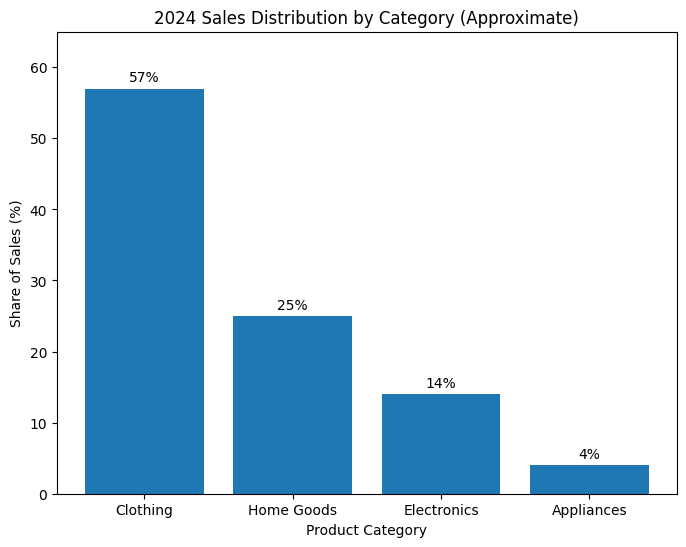

In [2]:
import matplotlib.pyplot as plt

# Approximate 2024 shares from earlier (normalized to 100%)
shares_2024 = {
    "Clothing": 57,
    "Home Goods": 25,
    "Electronics": 14,
    "Appliances": 4
}

# For visualization, we can treat percentages as "counts" out of 100
categories = list(shares_2024.keys())
values = list(shares_2024.values())

# Plot
plt.figure(figsize=(8,6))
plt.bar(categories, values)
plt.title("2024 Sales Distribution by Category (Approximate)")
plt.ylabel("Share of Sales (%)")
plt.xlabel("Product Category")

for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v}%", ha='center')

plt.ylim(0, 65)
plt.show()

/var/folders/rd/bzzc96fj7v9frj3zp_zwgn100000gn/T/ipykernel_32636/3765445409.py:11: RuntimeWarning: divide by zero encountered in log
  return x0 - (1/k) * np.log(L/y - 1)


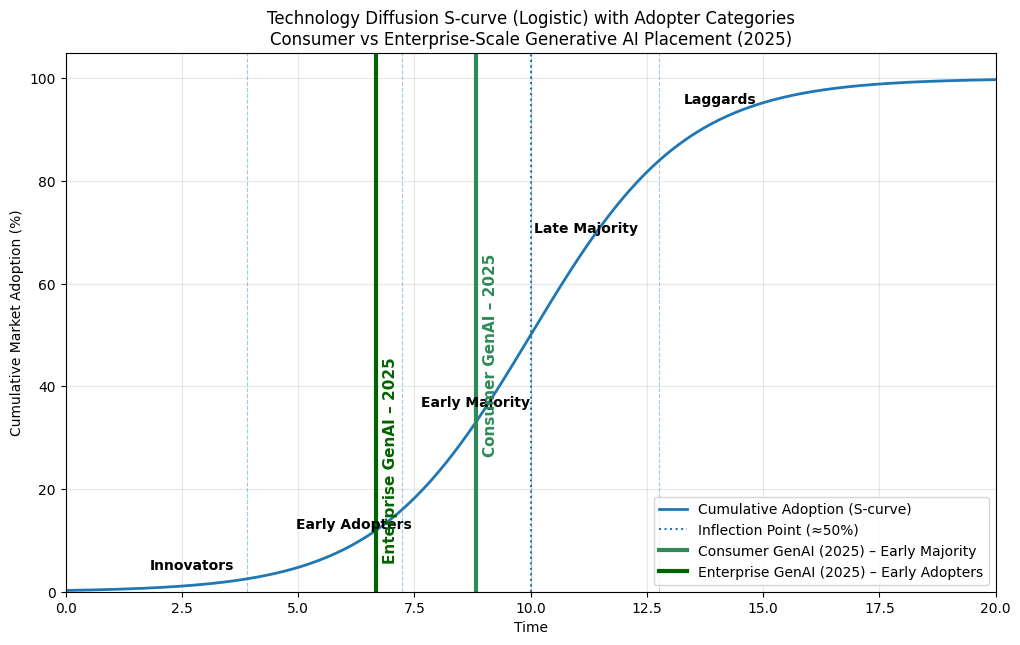

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- Logistic S-curve setup ---
time = np.linspace(0, 20, 500)

def logistic(t, L=100, k=0.6, x0=10):
    return L / (1 + np.exp(-k*(t - x0)))

def inv_logistic(y, L=100, k=0.6, x0=10):
    return x0 - (1/k) * np.log(L/y - 1)

curve = logistic(time)

# Category cumulative boundaries (%): Innovators 2.5, Early Adopters 16, Early Majority 50, Late Majority 84
boundaries_pct = [2.5, 16, 50, 84, 100]
boundary_x = [inv_logistic(p) for p in boundaries_pct]

# Category midpoint x-positions for labels
midpoints_pct = [(0+2.5)/2, (2.5+16)/2, (16+50)/2, (50+84)/2, (84+100)/2]
mid_x = [inv_logistic(p) for p in midpoints_pct]
cat_names = ["Innovators", "Early Adopters", "Early Majority", "Late Majority", "Laggards"]

# Placement per corrected request:
# Consumer GenAI: firmly in Early Majority, but not yet at inflection (≈30–35% adoption)
consumer_x = inv_logistic(33)  
consumer_y = logistic(consumer_x)

# Enterprise-scale GenAI: Early Adopters (~12% adoption)
enterprise_x = inv_logistic(12)  
enterprise_y = logistic(enterprise_x)

# --- Plot ---
plt.figure(figsize=(12,7))

# S-curve
plt.plot(time, curve, linewidth=2, label="Cumulative Adoption (S-curve)")

# Inflection point (50%)
plt.axvline(x=boundary_x[2], linestyle=":", linewidth=1.5, label="Inflection Point (≈50%)")

# Category boundary markers (light dashed)
for x in boundary_x[:-1]:  # skip 100%
    plt.axvline(x=x, linestyle="--", linewidth=0.8, alpha=0.4)

# Category labels
for name, x in zip(cat_names, mid_x):
    y = logistic(x)
    plt.text(x, y+3, name, ha="center", fontsize=10, fontweight="bold")

# User-specified markers
plt.axvline(x=consumer_x, color="seagreen", linewidth=3, label="Consumer GenAI (2025) – Early Majority")
plt.axvline(x=enterprise_x, color="darkgreen", linewidth=3, label="Enterprise GenAI (2025) – Early Adopters")

# Annotations
plt.text(consumer_x+0.15, consumer_y-6, "Consumer GenAI – 2025", rotation=90, color="seagreen", fontsize=11, fontweight="bold")
plt.text(enterprise_x+0.15, enterprise_y-6, "Enterprise GenAI – 2025", rotation=90, color="darkgreen", fontsize=11, fontweight="bold")

# Titles and axes
plt.title("Technology Diffusion S-curve (Logistic) with Adopter Categories\nConsumer vs Enterprise-Scale Generative AI Placement (2025)")
plt.xlabel("Time")
plt.ylabel("Cumulative Market Adoption (%)")
plt.ylim(0, 105)
plt.xlim(0, 20)
plt.legend()
plt.grid(alpha=0.3)

# Save for download
# plt.tight_layout()
# plt.savefig("/mnt/data/genai_diffusion_consumer_vs_enterprise_2025_corrected.png", dpi=220)

plt.show()